In [1]:
import torch
import requests
import zipfile
import os
import random
import matplotlib.pyplot as plt
import pathlib

from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch import nn
from torchinfo import summary

/Users/arjunlfc/Documents/workspace/_venv/pytorch/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Goal
Create custom datasets (usable within Pytoch) using random images downloaded from the internet

#### Other details
PyTorch includes many existing functions to load in various custom datasets in the TorchVision, TorchText, TorchAudio and TorchRec domain libraries.



#### Device Identification

In [2]:
def get_device():
    if torch.cuda.is_initialized():
        return 'cuda'
    if torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'

device = get_device()

# Downloading Data

In [3]:
def download_data(dir_path, filename):
    # Setup path to data folder
    data_path = Path(dir_path)
    image_path = data_path / filename
    
    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"{image_path} directory exists.")
    else:
        print(f"Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        with open(data_path / f"{filename}.zip", "wb") as f:
            request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
            print("Downloading pizza, steak, sushi data...")
            f.write(request.content)
    
        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / f"{filename}.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...") 
            zip_ref.extractall(image_path)

In [1]:
DATASET_PATH="datasets/"
FILENAME="pizza_steak_sushi"
download_data(DATASET_PATH, FILENAME)

# Setup train and testing paths
train_dir = f"{DATASET_PATH}{FILENAME}/train"
test_dir = f"{DATASET_PATH}{FILENAME}/test"

train_dir, test_dir

NameError: name 'download_data' is not defined

# Inspecting Data

In [5]:
def get_data_details(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
get_data_details(DATASET_PATH)

There are 3 directories and 0 images in 'datasets/'.
There are 1 directories and 0 images in 'datasets/FashionMNIST'.
There are 0 directories and 8 images in 'datasets/FashionMNIST/raw'.
There are 0 directories and 0 images in 'datasets/.ipynb_checkpoints'.
There are 2 directories and 0 images in 'datasets/pizza_steak_sushi'.
There are 3 directories and 0 images in 'datasets/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'datasets/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'datasets/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'datasets/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'datasets/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'datasets/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'datasets/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'datasets/pizza_steak_sushi/train/pizza'.


### Visualizing Image

Random image path: datasets/pizza_steak_sushi/train/pizza/3281494.jpg
Image class: pizza
Image height: 288
Image width: 512


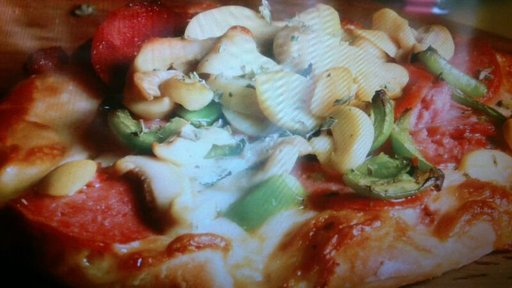

In [7]:
def visualize_img(image_path):
    image_path = Path(image_path)
    
    # 1. Get all image paths (* means "any combination")
    image_path_list = list(image_path.glob("*/*.jpg"))

    # 2. Get random image path
    random_image_path = random.choice(image_path_list)
    
    # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
    image_class = random_image_path.parent.stem
    
    # 4. Open image
    img = Image.open(random_image_path)

    # 5. Print metadata
    print(f"Random image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.height}") 
    print(f"Image width: {img.width}")
    return img

img = visualize_img(train_dir)
img

# Transformig Data

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

Since we're working with a vision problem, we'll be looking at torchvision.datasets for our data loading functions as well as torchvision.transforms for preparing our data.

## 1. Transforming image using torchvision.transforms

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the torchvision.transforms module.

torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes

To get experience with torchvision.transforms, let's write a series of transform steps that:

Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`.
We can compile all of these steps using `torchvision.transforms.Compose()`.

In [8]:
def transform_images_fn():
    data_transform = transforms.Compose([
        transforms.Resize(size=(64,64)),
        transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
        transforms.ToTensor(),
    ])

    return data_transform

In [9]:
def plot_images(dataset_img, dataset_labels, n):
    fig, axis = plt.subplots(n,n, figsize=(9,9))

    for i in range(n):
        for j in range(n):
            # print(dataset_img[i+j].shape, dataset_img[i+j].dtype)
            axis[i][j].imshow(dataset_img[i+j])
            axis[i][j].set_title(dataset_labels[i+j])

    plt.tight_layout()
    plt.show()

def compare_pics(dataset_img1, dataset_img2, dataset_labels, n):
    fig, axis = plt.subplots(n,n, figsize=(9,9))

    idx = 0
    for i in range(n):
        for j in range(n):
            if idx % 2 == 0:
                axis[i][j].imshow(dataset_img1[idx//2])
                axis[i][j].set_title(dataset_labels[idx//2])
            else:
                axis[i][j].imshow(dataset_img2[idx//2])
                axis[i][j].set_title(dataset_labels[idx//2]) 
            idx += 1

    plt.tight_layout()
    plt.show()

In [10]:
# Transforming a few random images
def transform_random_images(image_path, n=4):
    image_path = Path(image_path)
    image_path_list = list(image_path.glob("*/*.jpg"))

    dataset_img1 = []
    dataset_img2 = []
    labels = []
    for i in range(n*n):
        random_path = random.choice(image_path_list)
        img = Image.open(random_path)
        dataset_img1.append(img)
        label = random_path.parent.stem
        transform_img = transform_images_fn()(img)        
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        dataset_img2.append(torch.permute(transform_img, dims=(1,2,0))) # change the image from [3,64,64] to [64,64,3]
        labels.append(label)

    compare_pics(dataset_img1, dataset_img2, labels, n)

    

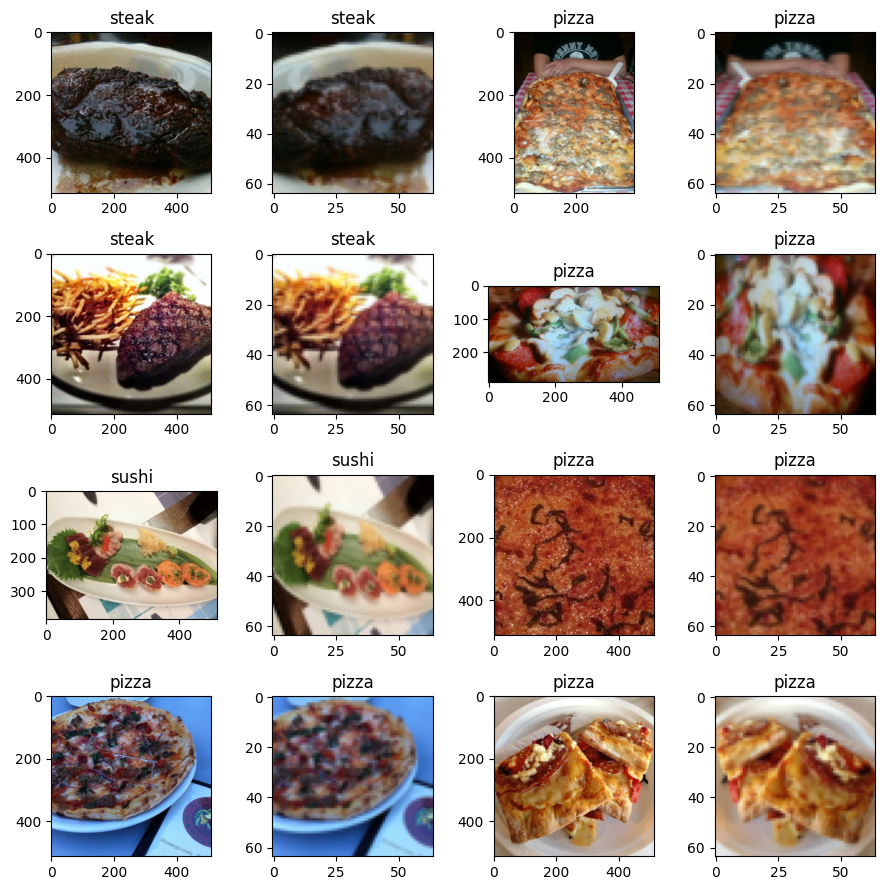

In [11]:
transform_random_images(train_dir, 4)

## (Option-1) 2.1 Turn the images into a torch.utils.Dataset

Alright, time to turn our image data into a Dataset capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class torchvision.datasets.ImageFolder.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

In [12]:
def create_dataset(filepath):
    # Use ImageFolder to create dataset(s)
    data = datasets.ImageFolder(root=filepath, # target folder of images
                                      transform=transform_images_fn(), # transforms to perform on data (images)
                                      target_transform=None) # transforms to perform on labels (if necessary)
    return data
    
train_data = create_dataset(train_dir)
test_data = create_dataset(test_dir)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: datasets/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: datasets/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
print(train_data.classes)
print(train_data.class_to_idx)
print(len(train_data), len(test_data))

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
225 75


In [14]:
img, cls = train_data[0]
print(img.dtype)
print(img.shape)
print(cls)

torch.float32
torch.Size([3, 64, 64])
0


## (Option-1) 2.2 Turn things into a Dataloader
Turning our Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).
To keep things simple, we'll use a `batch_size=1` and `num_workers=1`. `num_workers` defines how many subprocesses will be created to load your data. Higher value `num_workers` is set to, the more compute power PyTorch will use to load your data. 

In [15]:
def create_dataloader(dataset, shuffle=True, batch_size=1):
    dataloader = DataLoader(dataset=dataset, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

    return dataloader

train_dataloader = create_dataloader(train_data)
test_dataloader = create_dataloader(test_data, shuffle=False)

In [16]:
iter_train = iter(train_dataloader)
next(iter_train)

[tensor([[[[0.9569, 0.8118, 0.8784,  ..., 0.4157, 0.4471, 0.4824],
           [0.8471, 0.7765, 0.9137,  ..., 0.4314, 0.4824, 0.4431],
           [0.7059, 0.8353, 0.8980,  ..., 0.4392, 0.4706, 0.4510],
           ...,
           [0.6863, 0.6784, 0.6745,  ..., 0.6706, 0.6667, 0.6627],
           [0.6902, 0.6902, 0.6863,  ..., 0.6706, 0.6667, 0.6627],
           [0.7020, 0.7020, 0.6941,  ..., 0.6706, 0.6667, 0.6745]],
 
          [[0.8549, 0.6824, 0.7098,  ..., 0.2863, 0.3294, 0.3490],
           [0.7373, 0.6039, 0.7176,  ..., 0.3059, 0.3569, 0.3255],
           [0.5608, 0.6275, 0.7216,  ..., 0.3137, 0.3294, 0.3176],
           ...,
           [0.6196, 0.6118, 0.6000,  ..., 0.6196, 0.6157, 0.6118],
           [0.6157, 0.6235, 0.6196,  ..., 0.6196, 0.6157, 0.6118],
           [0.6157, 0.6235, 0.6235,  ..., 0.6196, 0.6157, 0.6235]],
 
          [[0.7373, 0.5686, 0.5686,  ..., 0.2667, 0.2941, 0.3216],
           [0.6314, 0.4863, 0.5647,  ..., 0.2706, 0.3059, 0.2902],
           [0.4667, 0.49

## (Option-2) 2.1 Turn the images into a torch.utils.Dataset
What if a pre-built Dataset creator like torchvision.datasets.ImageFolder() didn't exist? We can create a custom dataset.

Let's work towards replicating torchvision.datasets.ImageFolder() by subclassing torch.utils.data.Dataset (the base class for all Dataset's in PyTorch).

In [17]:
def find_classes(directory: str):
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

classes, class_to_idx = find_classes(train_dir)

In [18]:
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [19]:
# Create transforms
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [20]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x11950e4f0>,
 <__main__.ImageFolderCustom at 0x106253a30>)

In [21]:
print(len(train_data_custom), len(test_data_custom))
print(train_data_custom.classes)

225 75
['pizza', 'steak', 'sushi']


In [22]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1062536a0>,
 <torch.utils.data.dataloader.DataLoader at 0x11c9e4f10>)

# Other Data Augmentation

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set. You can see them all in the [torchvision.transforms documentation](https://pytorch.org/vision/stable/transforms.html).

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like transforms.RandAugment() and transforms.TrivialAugmentWide()) generally perform better than hand-picked transforms.

TrivialAugment and other accuracy improvements: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

TrivialAugment was one of the ingredients used in a recent state of the art training upgrade to various PyTorch vision models. The main parameter to pay attention to in transforms.TrivialAugmentWide() is `num_magnitude_bins`=31. It defines how much of a range an intensity value will be picked to apply a certain transform, 0 being no range and 31 being maximum range (highest chance for highest intensity).

In [23]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

# TinyVGG Model for Classification

### Dataset Creation and Dataloaders

In [24]:
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

Creating DataLoader's with batch size 32 and 11 workers.


In [52]:
for item, lables in test_dataloader_simple:
    print(item.shape)
    print(labels.shape)

torch.Size([32, 3, 64, 64])
torch.Size([11])
torch.Size([32, 3, 64, 64])
torch.Size([11])
torch.Size([11, 3, 64, 64])
torch.Size([11])


### Model

In [57]:
class TinyVGG(nn.Module):
    def __init__(self, channel_depth, input_channels, output_classes):
        super().__init__()
        # 3*64*64 -> channel_depth*30*30
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, 
                      out_channels=channel_depth, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel_depth, 
                      out_channels=channel_depth, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # channel_depth*30*30 -> channel_depth*13*13
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=channel_depth, 
                      out_channels=channel_depth, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel_depth, 
                      out_channels=channel_depth, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=channel_depth*13*13, 
                out_features=output_classes
            )
        )

    def forward(self, x):
        return self.classifier(self.block2(self.block1(x)))

tinyvgg_model = TinyVGG(channel_depth=20, input_channels=3, output_classes=len(train_data_simple.classes))

Note: One of the ways to speed up deep learning models computing on a GPU is to leverage operator fusion.

This means in the forward() method in our model above, instead of calling a layer block and reassigning x every time, we call each block in succession (see the final line of the forward() method in the model above for an example).

This saves the time spent reassigning x (memory heavy) and focuses on only computing on x.

### Using torchinfo for summary

In [58]:
summary(tinyvgg_model, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 20, 62, 62]           560
│    └─ReLU: 2-2                         [1, 20, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 20, 60, 60]           3,620
│    └─MaxPool2d: 2-4                    [1, 20, 30, 30]           --
├─Sequential: 1-2                        [1, 20, 13, 13]           --
│    └─Conv2d: 2-5                       [1, 20, 28, 28]           3,620
│    └─ReLU: 2-6                         [1, 20, 28, 28]           --
│    └─Conv2d: 2-7                       [1, 20, 26, 26]           3,620
│    └─MaxPool2d: 2-8                    [1, 20, 13, 13]           --
├─Sequential: 1-3                        [1, 3]                    --
│    └─Flatten: 2-9                      [1, 3380]                 --
│    

### Training/Testing Loop

In [70]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()    

    total_loss = 0
    total_accuracy = 0
    for batch, (X,y) in enumerate(dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()

        optimizer.step()
        total_loss += loss
        total_accuracy += ((torch.argmax(pred, dim=1) == y).sum().item()/len(y))

    total_loss /= len(dataloader)
    total_accuracy /= len(dataloader)
    return total_loss, total_accuracy

def eval_step(model, dataloader, loss_fn, device):
    model.eval()
    with torch.inference_mode():
        total_loss = 0
        total_accuracy = 0
        
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss
            total_accuracy += ((torch.argmax(pred, dim=1) == y).sum().item()/len(y))
        
        total_loss /= len(dataloader)
        total_accuracy /= len(dataloader)

    return total_loss, total_accuracy

In [71]:
def train_loop(model, train_dataloader, test_dataloader, loss_fn, optimizer_cls, n_epochs, device):
    optimizer = optimizer_cls(model.parameters(), lr=0.01)
    for i in range(n_epochs):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        # if i+1 % 5 == 0:
        test_loss, test_acc = eval_step(model, test_dataloader, loss_fn, device)
        print(f"train_acc: {train_acc} | train_loss: {train_loss} | test_loss: {test_loss} | test_acc: {test_acc}")

    return model

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam

In [73]:
trained_model = train_loop(tinyvgg_model.to(device), train_dataloader_simple, test_dataloader_simple, loss_fn, optimizer_cls, 10, device)

train_acc: 0.3046875 | train_loss: 2.6579861640930176 | test_loss: 1.074029564857483 | test_acc: 0.5416666666666666
train_acc: 0.2578125 | train_loss: 1.2465382814407349 | test_loss: 1.37948477268219 | test_acc: 0.19791666666666666
train_acc: 0.37109375 | train_loss: 1.1633042097091675 | test_loss: 1.00955069065094 | test_acc: 0.5416666666666666
train_acc: 0.3828125 | train_loss: 1.174092173576355 | test_loss: 1.357232689857483 | test_acc: 0.19791666666666666
train_acc: 0.41796875 | train_loss: 1.2734555006027222 | test_loss: 1.3323078155517578 | test_acc: 0.2604166666666667
train_acc: 0.41796875 | train_loss: 1.3080912828445435 | test_loss: 1.0426164865493774 | test_acc: 0.5416666666666666
train_acc: 0.27734375 | train_loss: 1.3199613094329834 | test_loss: 1.1549028158187866 | test_acc: 0.19791666666666666
train_acc: 0.2890625 | train_loss: 1.1525825262069702 | test_loss: 1.1505533456802368 | test_acc: 0.2604166666666667
train_acc: 0.27734375 | train_loss: 1.1240501403808594 | test_lo